<a href="https://colab.research.google.com/github/sir-sauc3/Project2/blob/main/Trial_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import numpy as np
from dataclasses import dataclass
from pprint import pprint
import random
from scipy.signal import correlate2d

import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.colors as colors

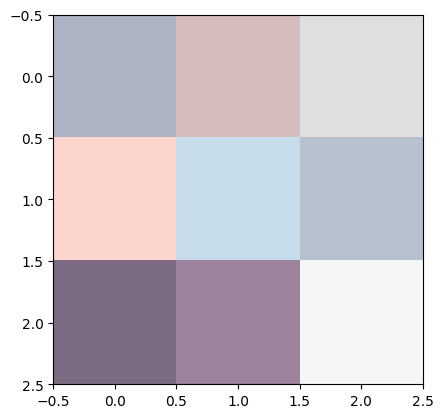

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Create two NumPy arrays of the same size
arr1 = np.random.rand(3, 3)
arr2 = np.random.rand(3, 3)

# Display the arrays over each other using imshow
fig, ax = plt.subplots()
ax.imshow(arr1, cmap='Blues', alpha=0.5)
ax.imshow(arr2, cmap='Reds', alpha=0.3)
plt.show()

[[0.17829824 0.22266953 0.59608041]
 [0.01721837 0.36214306 0.16644204]
 [0.74940169 0.30574121 0.0836735 ]]


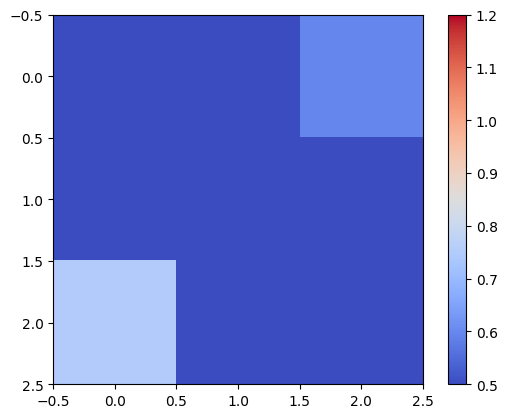

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 3x3 NumPy array with random values
arr = np.random.rand(3, 3)

print(arr)
# Display the array using a custom colormap
fig, ax = plt.subplots()
im = ax.imshow(arr, cmap='coolwarm', vmin=0.5, vmax=1.2)

# Add a colorbar to show the mapping of values to colors
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()

[[-0.71248663  0.75872284  1.67702893]
 [-0.38082972  1.38316865  0.27357846]
 [-0.12703475 -0.85995381 -0.98246791]]


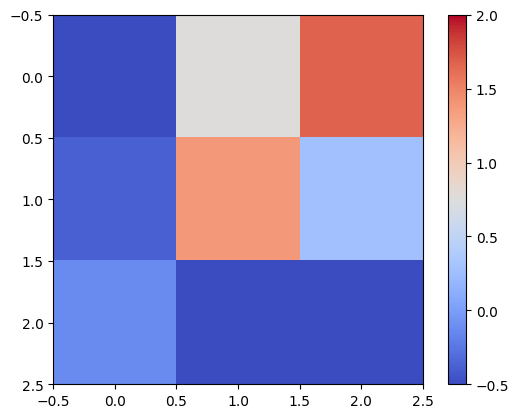

In [78]:
import numpy as np

arr = np.random.uniform(low=-1, high=2, size=(3, 3))

print(arr)
fig, ax = plt.subplots()
im = ax.imshow(arr, cmap='coolwarm', vmin=-0.5, vmax=2.0)

# Add a colorbar to show the mapping of values to colors
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()

In [79]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [89]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(5, 5)): #frames=50, steps_per_frame=1, figsize=(8, 8)
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames, interval=50)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [81]:
class Deer:

  def __init__(self, location, weight=25, **grid_size): #honestly didnt need to use **grid_size as a kwarg but since we know what it is we wanted to try it out
    self.location = tuple(location)
    self.weight = weight
    self.gridsize= grid_size['grid_size']

  def cardinal_neighbors(self):
    x = self.location[0]
    y = self.location[1]
    return [((x-1)%self.gridsize, y), (x, (y+1)%self.gridsize), ((x+1)%self.gridsize, y), (x, (y-1)%self.gridsize)]
    #this turned out to be a really neat way to get the cardinal neighbors of a cell compared to the other verbose conditional statements
    #we tried before. The modulus function helps any cell on the edge get its cardinal neighbor thats wrapped around the grid

In [102]:
class Grazing_simulation:

  #we thought of using a kernel in order to make the deer 'smart' in terms of making decisions on the next cell to move to but
  #this move almost made us save many trips to the barber shop

  cmap = [(1, 0.5, 0), (0, 1, 0)] # colors used for a dry cell and a vegetated cell
  grazing_colour_map = matplotlib.colors.ListedColormap(cmap)


  def __init__(self, size, coverage, num_deer, max_weight=50, metabolism=6):
      self.size = size
      self.coverage = coverage
      self.num_deer = num_deer
      self.max_weight = max_weight
      self.metabolism = metabolism

      self.grassland = np.random.choice([1,0], (size,size), p=(coverage, 1-coverage))

      self.introduce_deer()

  def introduce_deer(self):
      locs = [(x,y) for x in range(self.size) for y in range(self.size)] #makes a list of all possible locations
      np.random.shuffle(locs) # shuffles the locations

      assert(self.num_deer <= len(locs)) #makes sure that the desired number of deer can actually fit on the grid
      self.deers = [Deer(locs[i], grid_size = self.size) for i in range(self.num_deer)] # generates desired number of deer using Deer class
      # for deer in self.deers:
      #           xs, ys = deer.location
      #           points = plt.plot(xs, ys, '.', color='brown', markersize=30)

  def move_deer(self, deer):
      cardinal_neighbors = deer.cardinal_neighbors() # gets list of deer's cardinal neighbors
      available_to_move = [(x,y) for x,y in cardinal_neighbors if (x,y) not in self.occupied_locations] #checks cardinal neighbors against whats already occupied
      if (len(available_to_move) > 0): # if there are available places to move to
        self.occupied_locations.remove(deer.location)
        deer.location = random.choice(available_to_move)
        self.occupied_locations.append(deer.location)
      else: # basically means deer is 'stuck' between other deer and therefore stays put
        return


  def step(self):
    self.occupied_locations = [deer.location for deer in self.deers]
    
    for deer in self.deers:
      self.move_deer(deer)

      xs, ys = deer.location
      points = plt.plot(xs, ys, '.', color='brown', markersize=(30))


  def draw(self, axes=None, step=''):
      """Draws the CA cells using the forest colour map so values are coloured intuitively."""
      axes = axes or plt.axes
      title = f'Time:{step}\nNumber of deer present: {len(self.deers)}'
      plot_2D_array(self.grassland, axes=axes, title=title,
                    cmap=self.grazing_colour_map, vmin=0, vmax=len(self.grazing_colour_map.colors))

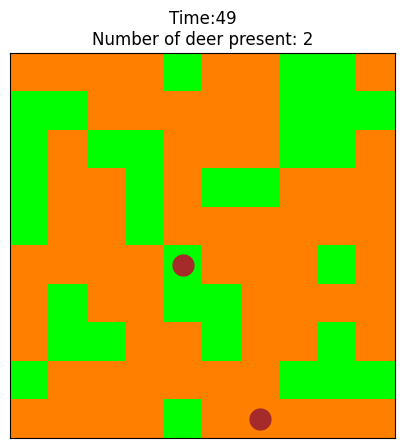

In [104]:
n=10
q=0.4
num_deer = 2
arr = Grazing_simulation(n, q, num_deer)

# print(arr.grassland)

see = Animation2D(arr)
see.animate()
# arr.step()
# see.animate()

In [105]:
#CHECKING FOR AVAILABLE LOCATIONS ON THE GRID

num = 9
other = np.random.choice([1,0], (3,3), p=(0.5,0.5))


i,j = other.shape
locs = [(x,y) for x in range(i) for y in range(j)]
np.random.shuffle(locs)

assert(num <= len(locs))
deers = [Deer(locs[i], grid_size=3) for i in range(num)]
occupied = [deer.location for deer in deers]

for deer in deers:
  pprint(f'Deer location: {deer.location}. Deer weight: {deer.weight}')


available_loc = [(x,y) for x in range(i) for y in range(j) if (x,y) not in occupied]
print(f'Available locations: {available_loc}')

'Deer location: (1, 2). Deer weight: 25'
'Deer location: (2, 1). Deer weight: 25'
'Deer location: (1, 1). Deer weight: 25'
'Deer location: (2, 0). Deer weight: 25'
'Deer location: (1, 0). Deer weight: 25'
'Deer location: (2, 2). Deer weight: 25'
'Deer location: (0, 0). Deer weight: 25'
'Deer location: (0, 2). Deer weight: 25'
'Deer location: (0, 1). Deer weight: 25'
Available locations: []


In [86]:
#MAKING THE DEER MOVE

#####################
# 1) get occupied locations (list)
# 2) get cardinal neighbors (list)
# 3) get cardinal neighbors in (2) that are not in (1). if length of list > 0 delete current position from occupied. if length = 0 stay put and break
# 4) pick random cardinal neighbor in (3) and make it the deer's new position
# 5) add (4) to (1)


# it would help if we made a cardinal_neighbor function in the Deer class